In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# load the data file
users = pd.read_csv('takehome_users.csv', encoding = 'ISO-8859-1')
engagement = pd.read_csv('takehome_user_engagement.csv')

In [3]:
# quickly check the dataset
users.head().T

,0,1,2,3,4
object_id,1,2,3,4,5
creation_time,2014-04-22 03:53:30,2013-11-15 03:45:04,2013-03-19 23:14:52,2013-05-21 08:09:28,2013-01-17 10:14:20
name,Clausen August,Poole Matthew,Bottrill Mitchell,Clausen Nicklas,Raw Grace
email,AugustCClausen@yahoo.com,MatthewPoole@gustr.com,MitchellBottrill@gustr.com,NicklasSClausen@yahoo.com,GraceRaw@yahoo.com
creation_source,GUEST_INVITE,ORG_INVITE,ORG_INVITE,GUEST_INVITE,GUEST_INVITE
last_session_creation_time,1.39814e+09,1.39624e+09,1.36373e+09,1.36921e+09,1.35885e+09
opted_in_to_mailing_list,1,0,0,0,0
enabled_for_marketing_drip,0,0,0,0,0
org_id,11,1,94,1,193
invited_by_user_id,10803,316,1525,5151,5240


In [4]:
# quickly check the dataset
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


The visited column in the engagement dataset doesn't give us too much information, let's drop it

In [7]:
# drop visited
engagement = engagement.drop('visited', axis = 1)

Convert the time_stamp to datetime object

In [8]:
engagement.time_stamp =  pd.to_datetime(engagement.time_stamp)

In [9]:
engagement.head()

,time_stamp,user_id
0,2014-04-22 03:53:30,1
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2
3,2013-12-09 03:45:04,2
4,2013-12-25 03:45:04,2


Get the adopted users

In [10]:
# convert the frequency of the time_stamp to daily frequency
engagement.time_stamp = engagement.time_stamp.dt.floor('D')

# drop duplicated time_stamp for each user
engagement = engagement.sort_values(['user_id','time_stamp']).drop_duplicates()

# get the adopted users who has logged into the product on three seprate days in at least one seven-day period
day_passed = pd.concat([engagement.groupby('user_id')['time_stamp'].diff(periods = 2).dt.days,engagement.user_id],axis = 1)

# as long as three consecutive log-in is within 7 days we say that user is an adopted user 
adopted_usr = day_passed[day_passed.time_stamp <= 7].user_id.unique()
num_adopted_usr = day_passed[day_passed.time_stamp <= 7].user_id.nunique()
print('There are {} adopted users'.format(num_adopted_usr))

There are 1656 adopted users


We can now convert the object_id in the users data set based on the adopted_usr list we got previously to show if the user is an adopted user or not, and this will also be our target value to predict

In [95]:
# make a copy of the original dataset
df = users.copy()

# convert the object_id to show the user is adopted user or not, 1 for adopted user, 0 for non-adopted user
df.object_id = df.object_id.apply(lambda x: x in adopted_usr).astype('int64')

# rename the column
df = df.rename(columns = {'object_id':'adopted_user'})
df.head().T

,0,1,2,3,4
adopted_user,0,1,0,0,0
creation_time,2014-04-22 03:53:30,2013-11-15 03:45:04,2013-03-19 23:14:52,2013-05-21 08:09:28,2013-01-17 10:14:20
name,Clausen August,Poole Matthew,Bottrill Mitchell,Clausen Nicklas,Raw Grace
email,AugustCClausen@yahoo.com,MatthewPoole@gustr.com,MitchellBottrill@gustr.com,NicklasSClausen@yahoo.com,GraceRaw@yahoo.com
creation_source,GUEST_INVITE,ORG_INVITE,ORG_INVITE,GUEST_INVITE,GUEST_INVITE
last_session_creation_time,1.39814e+09,1.39624e+09,1.36373e+09,1.36921e+09,1.35885e+09
opted_in_to_mailing_list,1,0,0,0,0
enabled_for_marketing_drip,0,0,0,0,0
org_id,11,1,94,1,193
invited_by_user_id,10803,316,1525,5151,5240


Create a new feature that is equal to the time difference between the creation_time and the last_session_creation_time. The assumption is that the possibility of being an adopted user for a user who still login to the product long after signing up maybe higher

In [117]:
# convert into the datetime format
df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time, unit = 's')

# get the difference between last_session_creation_time and the creation_time in the unit of day
df['account_last'] = (df.last_session_creation_time - df.creation_time).dt.days

# fill the missing value to be 0, assuming they never login again after signing up the account
df['account_last'] = df.account_last.fillna(0)

Remove features that are not useful and convert the invited_by_user to if they are invited by adopted user

In [119]:
# drop the not useful features such as the name and email
df = df.drop(['creation_time','name','email','last_session_creation_time','org_id'],axis = 1)

# convert the invited_by_user_id to if they are invited by adopted user
df.invited_by_user_id = df.invited_by_user_id.apply(lambda x: x in adopted_usr).astype('int64')
df = df.rename(columns = {'invited_by_user_id':'invited_by_adopted_usr'})

### EDA

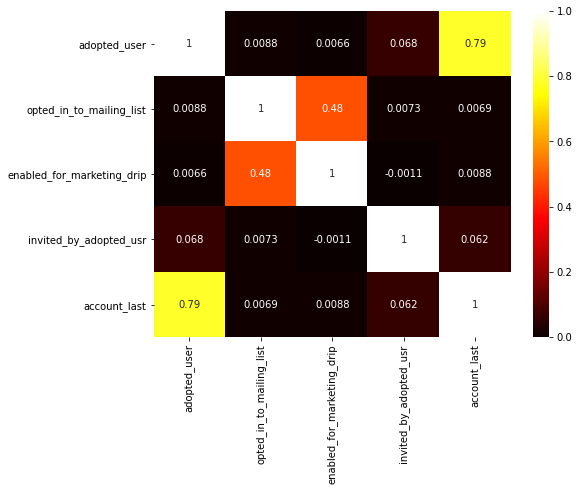

In [120]:
# Plot the correlation heat map
corr = df.corr()
plt.figure(figsize=(8,6))
_=sns.heatmap(corr, cmap = 'hot', annot = True)

As expected the account last feature has high correlation with our target value adopted_user. Not much correlation can be seen between other features and the adopted user. Next let's take a look at the categorical feature - creation_source

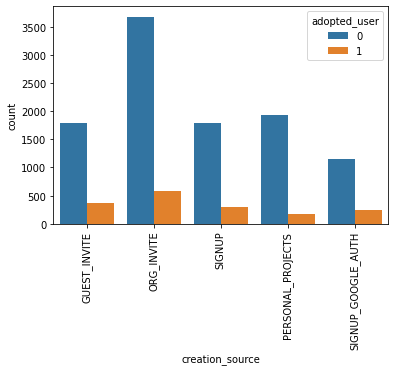

In [14]:
_ = sns.countplot(x='creation_source', hue = 'adopted_user', data = df)
_ = plt.xticks(rotation=90)

In [15]:
# get percentage of adopted user for each creation source
df.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.170596
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
SIGNUP                0.144705
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

Besides seeing that user who signed up for personal projects has lower adopted rate, there is not much difference between each group

### Modeling

In [55]:
# import necessary packages
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, plot_confusion_matrix

In [121]:
df_clean = df.copy()
df_clean = pd.get_dummies(df_clean, drop_first = True)
kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

In [122]:
# prepare test and train set
X = df_clean.drop(['adopted_user'],axis=1).values
y = df_clean.adopted_user.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True, stratify = y)

Let's use Logistic Regression to quickly model the data

In [125]:
# Initialize model, since the data is imbalanced, we set the class weight paramber to be balanced
lr = LogisticRegression(solver='liblinear', random_state = 0, class_weight = 'balanced')

# setup hyperparameters for model tuning
param_grid_lr = {'penalty':['l1','l2'], 'C':[0.1,1,10,100]}

# Train Logistic Regression
cv = RandomizedSearchCV(lr, param_distributions = param_grid_lr, n_iter = 6, cv = kfold, scoring = 'precision')
cv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=0,
                                                solver='liblinear', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=6, n_jobs=None,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=

In [129]:
# Make prediction
y_pred = cv.predict(X_test)
y_pred_prob = cv.predict_proba(X_test)[:,1]

In [130]:
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test,y_pred)))
print('AUC: {}'.format(roc_auc_score(y_test, y_pred_prob)))

Accuracy: 0.9620833333333333
Precision: 0.8174603174603174
Recall: 0.9335347432024169
AUC: 0.9931297721070209


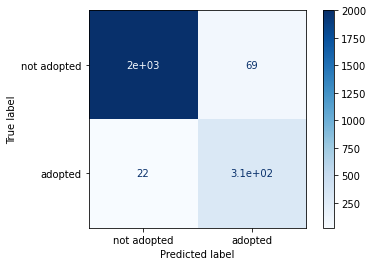

In [128]:
# Plot confusion matrix
_= plot_confusion_matrix(cv, X_test, y_test,
                      display_labels = ['not adopted','adopted'],
                      cmap=plt.cm.Blues)

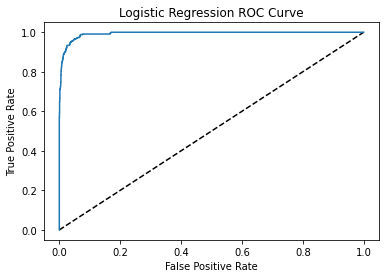

In [132]:
# Plot ROC curve
fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('{} ROC Curve'.format('Logistic Regression'))
plt.show()

In [150]:
cv.best_estimator_.coef_

array([[ 0.25402656, -0.33647144,  0.92305411,  0.09084592,  0.06905611,
         0.01011796,  0.00378586,  0.34128149]])

In [140]:
df_clean.columns

Index(['adopted_user', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'invited_by_adopted_usr', 'account_last',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [142]:
df_clean.drop(['adopted_user'],axis=1).columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'invited_by_adopted_usr', 'account_last', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')